In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
# 显示图像
def img_show(img):
    if len(img.shape) == 3:
        if img.shape[-1]==3:
            b,g,r = cv2.split(img)
            img = cv2.merge([r,g,b])
        elif img.shape[-1]==4:
            b,g,r,a = cv2.split(img)
            img = img
        plt.imshow(img)
    elif len(img.shape) == 2:
        plt.imshow(img)

In [3]:
# 随机加椒盐函数
def salt(img,n):
    # 循环添加n个椒盐
    for k in range(n):
        # 随机添加椒盐的坐标
        i = int(np.random.random()*img.shape[0])
        j = int(np.random.random()*img.shape[1])
        # 若位灰度图
        img[i,j] = 255
        # 若为RGB图
        img[i,j,0] = 255
        img[i,j,0] = 255
        img[i,j,0] = 255
    return img

In [4]:
# 清洗锐化图片
def cleaning(img):
    bgr = cv2.split(img)
    bgrNew = []
    for c in bgr:
        c = cv2.threshold(c,127,255,cv2.THRESH_BINARY)
        bgrNew.append(c[1])
    img = cv2.merge(bgrNew)
    return img

hand = cv2.imread("/Users/tanjun/Desktop/tanjun/opencv/hand.png")
cleaning(hand)
cv2.imwrite("/Users/tanjun/Desktop/tanjun/opencv/hand.png",hand)

True

In [6]:
# 模版匹配：在当前图像A内寻找与图像B最相似的部分
# 一般将图像A称为输入图像，将图像B称为模版图像
# 查找方式：将图像B在图像A内滑动，逐个像素遍历

# 15.1 模版匹配基础

In [5]:
# 在opencv中，使用函数cv2.matchTemplate()实现模版匹配

# result = cv2.matchTemplate(image,templ,method[,mask])
# 参数：
# imgage： 原始图像，必须是8位或32位浮点型图像
# templ：模版图像，尺寸必须小于或等于原始图像，且与原始图像同类型
# method：匹配方法，该参数通过TemplateMatchModes实现，有6种可能值：（见书P340）
# cv2.TM_SQDIFF        0 以方差为依据进行匹配，若完全匹配，结果为零；若不匹配，得到一个很大的值
# cv2.TM_SQDIFF_NORMED 1 标准（归一化）平方差匹配
# cv2.TM_CCORR         2 相关匹配，这类方法将模版图像与输入图像相乘，面积较大，匹配程度高；乘积为0，匹配程度最差
# cv2.TM_CCORR_NORMED  3 标准（归一化）平方差匹配
# cv2.TM_CCOEFF        4 相关系数匹配，该类方法将模版图像与其均值的相对值，和输入图像与其均值的相对值进行匹配，1完美，-1糟糕，0无相关性
# cv2.TM_CCOEFF_NOMED  5 标准（归一化）平方差匹配
# mask：模版图像掩模。必须和模版图像同大小，同类型。当前该参数仅支持TM_SQWDIFF,TM_CCORR_NORMED两种
# 返回值：
# result：是由每个位置的比较结果组成的结果集，类型是32位浮点型，如果输入图像尺寸是W*H，模版尺寸是w*h，返回值尺寸为(W-w_1)*(H-h+1)

# 注意：参数method决定了结果的评价标准：
# 当method为cv2.TM_SQDIFF和cv2.TM_SQDIFF_NORMED时，result=0匹配最好，值越大越差
# 当method为cv2.TM_CCORR、cv2.TM_CCORR_NORMED、cv2.TM_CCOEFF、cv2.TM_CCOEFF_NOMED时，result值越大匹配越好，越小越差

# 查找最值（极值）与最值所在位置，可以用cv2.minMaxLoc():
# minVal,maxVal,minLoc,maxLoc = cv2.minMaxLoc(src[,mask])
# src：单通道数组
# minVal：最小值，如果没有，可以是Null
# maxVal：最大值，如果没有，可以是Null
# minLoc：最小值位置，如果没有，可以是Null
# maxLoc：最大值位置，如果没有，可以是Null
# cv2.minMaxLoc()可以查找整个数组内的最值及它们的位置，并且能够根据当前掩模集来选取特定子集的极值，参见12章

# 综上，cv2.matchTemplate()返回值中的最值位置就是模版匹配的位置
# 通过函数cv2.minMaxLoc()来查找函数cv2.matchTemplate()返回值中的最值位置，就可以找到最佳模版的位置

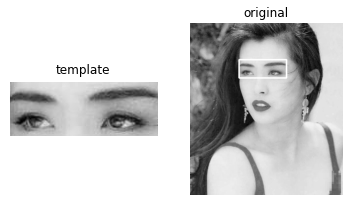

In [29]:
wzx = cv2.imread("/Users/tanjun/Desktop/tanjun/opencv/wzx.jpg",0)

# 模版
template = wzx[120:180,160:315]
h,w = template.shape[::]

# 模版匹配
rv = cv2.matchTemplate(wzx,template,cv2.TM_SQDIFF)
minVal,maxVal,minLoc,maxLoc = cv2.minMaxLoc(rv)

# 最佳匹配
topLeft = minLoc
bottomRight = (topLeft[0]+w,topLeft[1]+h)
cv2.rectangle(wzx,topLeft,bottomRight,255,3)

# 显示
plt.subplot(121),plt.imshow(template,cmap="gray"),plt.title("template"),plt.axis("off")
plt.subplot(122),plt.imshow(wzx,cmap="gray"),plt.title("original"),plt.axis("off")
plt.show()

# 注意：
# 这里计算模版图像的宽度时，使用的语句为：h,w = template.shape[::]
# opencv中使用的语句为：w,h = template.shape[::-1],调换了返回值顺序

# 15.2 多模版匹配

In [30]:
# 上方例子中，眼部信息只出现了一次，但有些情况下要搜索的图像中模版图像在输入图像中可能出现了多次，这时要找出多个匹配结果
# cv2.minMaxLoc()只能找出最值，不能给出所有匹配区域的位置信息，所以想要匹配多个结果，该函数无法实现，需要利用阈值处理

# 获取多模版匹配结果步骤：
# 1.获取匹配位置集合
# 函数where()能获取模版匹配位置的集合。对于不同的输入，其返回值是不同的
# 当输入是一维数组时，返回只是一维索引，只有一组索引数组
# 当输入是二维数组时，返回的是匹配值的位置索引，因此会有两组索引数组表示返回值的位置
# 综上所述，函数np.where()可以找出在函数cv2.matchTemplate()返回值中，哪些位置上的值是大于阈值的：
# loc = np.where(res>=threshold)
# res：函数cv2.matchTemplate()进行模版匹配后的返回值
# threshold：阈值
# loc：res>threshold的像素点的集合

# 2.循环
# 要处理多个值，通常需要循环
# 因此，在获取匹配值的索引集合后，可以使用循环语句遍历所有匹配的位置，对这些位置做标记

# 3.在循环中使用zip()
# 函数zip()用可迭代对象作为参数，将对象中对应的元素打包成一个个元组，让偶返回由这些元祖组成的列表

# 4.调整坐标值
# 函数np.where()可以获取满足条件的模版匹配位置集合，然后可以使用cv2.rectangle()在上述匹配位置桑绘制矩形来标注匹配位置
# 使用函数np.where()在函数cv2.matchTemplate()的输出值中查找指定值，得到的形式为（行号，列号）的位置索引
# 但cv2.rectangle()中指定顶点的参数使用的是（列号，行号）的位置索引
# 所以，在使用函数cv2.rectangle()前先要将函数np.where()得到的位置索引做行列互换，可以使用loc[::-1]语句实现行列互换

# 5.标记匹配图像的位置
# cv2.rectangle()
# 其中一个对角顶点A，可以通过for循环从确定的满足条件的匹配位置集合获取
# 另一个对角顶点，可以通过顶点A的位置与模版宽高运算获取

In [32]:
# 查找一维数组中数值>5的元素索引
a = np.array([3,6,8,1,2,88])
b = np.where(a>5)
b

(array([1, 2, 5]),)

In [35]:
# 查找二维数组中数值>5的元素索引
a = np.array([[3,6,8,77,66],[1,2,88,3,98],[11,2,67,5,2]])
b = np.where(a>5)
b
# 结果是（行索引数组，列索引数组），它们一一对应，如[0,1],[0,2]...位置上的数值大于5

(array([0, 0, 0, 0, 1, 1, 2, 2]), array([1, 2, 3, 4, 2, 4, 0, 2]))

In [45]:
# zip()返回元组列表
a = np.array([[3,6,8,77,66],[1,2,88,3,98],[11,2,67,5,2]])
b = np.where(a>5)
# c = list(zip(b[0],b[1]))
c = list(zip(*b))
c

[(0, 1), (0, 2), (0, 3), (0, 4), (1, 2), (1, 4), (2, 0), (2, 2)]

In [46]:
# 调整坐标
a = np.array([[3,6,8,77,66],[1,2,88,3,98],[11,2,67,5,2]])
b = np.where(a>5)[::-1]
c = list(zip(*b))
c

[(1, 0), (2, 0), (3, 0), (4, 0), (2, 1), (4, 1), (0, 2), (2, 2)]

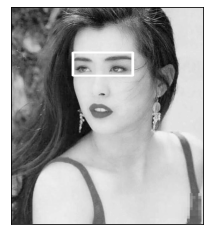

In [53]:
wzx = cv2.imread("/Users/tanjun/Desktop/tanjun/opencv/wzx.jpg",0)

# 模版
template = wzx[120:180,160:315]
w,h = template.shape[::-1]

# 模版匹配
res = cv2.matchTemplate(wzx,template,cv2.TM_CCOEFF_NORMED)

# 阈值过滤
threshold = 0.9
loc = np.where(res>=threshold)
loc = loc[::-1]
for p in zip(*loc):
    cv2.rectangle(wzx,p,(p[0]+w,p[1]+h),255,1)

# 显示
plt.imshow(wzx,cmap="gray")
plt.xticks([])
plt.yticks([])
plt.show()

# 可以看到，cv2.rectangle()设置的线宽为1，但实际画出来的线远大于1，这是因为在这个区域内存在多个大于阈值的情况